<a href="https://colab.research.google.com/github/jeonghojo00/ImageCaptioning/blob/main/ImgCaptioning_Transformer_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Initialization

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning
captions_val2014_fakecap_results.json  lstm_decoder.py
captions_val2014.json		       main.py
checkpoint			       model
code				       models
cs7643-final-project		       models.py
data				       pretraining.py
data_loader.py			       __pycache__
efficientnet.py			       resize_image.py
eval.pkl			       resnet.py
experiments			       show_attend_tell.py
image_captioning_loss_200731_2.pkl     split_caption.py
image_captioning_loss_200731.pkl       util
inception.py			       utils.py
inf_result.pkl			       vgg.py
learned_model.npy		       vocab.pkl
learned_models			       vocabulary.py
load_data.py


In [ ]:
import sys
import subprocess
import pkg_resources

required = {'efficientnet_pytorch', 'timm', 'tqdm', 'torch', 'torchvision'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [ ]:
# Import Libraries
import os
from PIL import Image
from tqdm import tqdm
import pickle
import nltk
from collections import Counter
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch.optim as optim 
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from load_data import *
from resize_image import *
from split_caption import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#1. Preparation of Images (Train/Val/Test split)

## Preprocess images

In [ ]:
# Define data folder
image_dir = './data/flickr8k/Images'
caption_path = './data/flickr8k/captions.txt' # Original caption file with path

train_image_dir = './data/flickr8k/train/Images' # Resized train images folder
val_image_dir = './data/flickr8k/val/Images' # Resized validation images folder
test_image_dir = './data/flickr8k/test/Images' # Resized test images folder
train_caption_path = "./data/flickr8k/train/captions.txt" # Resized train images' captions
val_caption_path = "./data/flickr8k/val/captions.txt" # Resized validation images' captions
test_caption_path = "./data/flickr8k/test/captions.txt" # Resized test images' captions
num_train_images = 6000
num_val_images = 1000


vocab_path = "./vocab.pkl" # vocabulary file
word_threshold = 4 # Minimum occurrances of words

resizeImage_required = False
if resizeImage_required == True:
    save_resized_images(image_dir, train_image_dir, val_image_dir, test_image_dir, num_train_images, num_val_images, resize_size=None)

## Preprocess captions for vocab dictionary and caption divisions

In [ ]:
splitCaption_required = False

if splitCaption_required == True:
    split_caption(caption_path, train_caption_path, val_caption_path, test_caption_path, vocab_path, num_train_images, num_val_images, word_threshold)

In [ ]:
# Number of Traning data
!wc -l ./data/flickr8k/train/captions.txt
# Number of Validation data
!wc -l ./data/flickr8k/val/captions.txt
# Number of Testing data
!wc -l ./data/flickr8k/test/captions.txt

30000 ./data/flickr8k/train/captions.txt
5000 ./data/flickr8k/val/captions.txt
5455 ./data/flickr8k/test/captions.txt


#2. Build Model

## 2.1 Patch Embedding

In [ ]:
class PatchEmbed(nn.Module):
    """Split images into patches and embed them

    Paramters
    ---------
    img_size : int
        Input size(Height or Width) of an image (it is square)
    
    patch_size : int
        Patch size to be splitted
    
    in_chans : int
        Number of channels (1 or gray scale and 3 for RGB)

    Attributes
    ----------
    num_patches : int
        Number of patches per image
    
    embed_dim : int
        Feature dimension

    patches : nn.Conv2d
        Convolution layer that splits an images into patches and embedding them
    """
    def __init__(self, img_size, patch_size = 16, in_chans = 3, embed_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.n_patches = (img_size//patch_size)**2
        
        self.patching = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
    def forward(self, x):
        """Run forward pass

        Parmaters
        ---------
        x : torch.Tensor
            Shape: (n_samples, in_chans, img_size, img_size)
        
        Returns
        -------
        torch.Tensor

            Shape : (n_samples, num_patches, embed_dim)
        """
        out = self.patching(x) # (n_samples, embed_dim, H/patch_size, W/patch_size)
        out = out.flatten(2)   # (n_samples, embed_dim, num_patches)
        out = out.permute(0, 2, 1) # (n_samples, num_patches, embed_dim)

        return out


In [ ]:
# Example of patching
imgs = torch.ones([3, 3, 384, 384])
img_size = imgs.shape[2]
patch_size = 16
in_chans = imgs.shape[1]
embed_dim = (patch_size**2) * in_chans
patching = PatchEmbed(img_size = img_size, patch_size = patch_size, in_chans = in_chans, embed_dim = embed_dim)

print("Input shape: ", imgs.shape)
afterPatch = patching(imgs)
print("Shapes after Patching: ", afterPatch.shape)
print(f"{afterPatch.shape[0]} : image channels, \n{afterPatch.shape[1]} : number of patches, \n{afterPatch.shape[2]} : embedding dimension")

Input shape:  torch.Size([3, 3, 384, 384])
Shapes after Patching:  torch.Size([3, 576, 768])
3 : image channels, 
576 : number of patches, 
768 : embedding dimension


## 2_2. Transformer (Custom)

In [ ]:
import math

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, embed_dim, dropout = 0.1):
        super().__init__()
        
        self.d_model = embed_dim
        self.d_k = embed_dim // n_heads
        self.h = n_heads
        
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output


class FFN(nn.Module):
    """Feed Forward Network (Multilayer perceptron)
    
    Parameters
    ----------
    in_features : int
        Number of input features
    
    hidden_features : int
        Number of nodes in the hidden layer

    out_features : int
        Number of output features

    dropout : float
        Dropout proability
    
    Attributes
    ----------
    fc1 : nn.Linear
        The first linear layer

    fc2 : nn.Linear
        The second linear layer

    drop : nn.Dropout
        Dropout layer
    """
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x):
        """Run forward pass
        FFN(x) = FC2(Dropout(GELU(FC1(x))))

        Parameters
        ----------
        x : torch.Tensor
            Shape : (n_samples, n_patches, in_features)

        Returns
        -------
        torch.Tensor
            Shape : (n_samples, n_patches, out_features)
        """
        out = self.drop(F.gelu(self.fc1(x))) # (n_samples, n_patches, hidden_features) 
        out = self.fc2(out)  # (n_samples, n_patches, out_features) 
        return out

class EncoderBlock(nn.Module):
    """Transformer Encoder block

    Parameters
    ----------
    embed_dim : int
        Embedding dimension

    n_heads : int
        Number of attention heads
    
    mlp_ratio : float
        Determines the hidden dimension size of the MLP module with respect to dim

    attn_p, ffn_p : float
        Dropout probability

    Attributes
    ----------
    norm1, norm2 = LayerNorm
        Layer normalization for each block

    attn : Attention
        Attention Module

    ffn : FFN
        FFN Module
    """
    def __init__(self, embed_dim, n_heads, mlp_ratio = 4.0, attn_p=0.0, ffn_p=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.norm2 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.attn = MultiHeadAttention(n_heads = n_heads, 
                                       embed_dim = embed_dim,
                                       dropout=attn_p)
    
        hidden_features = int(embed_dim * mlp_ratio)
        self.ffn = FFN(embed_dim, 
                       hidden_features = hidden_features, 
                       out_features = embed_dim,
                       dropout=ffn_p)

    def forward(self, x, mask=None):
        attention = self.attn(x, x, x, mask)
        out = self.norm1(attention+x)

        forward = self.ffn(out)
        out = self.norm2(forward + out)

        return out

class PositionalEncoding(nn.Module):
    """Positional Encoding

    Parameters
    ----------
    embed_dim : int
        Embedding dimension
    
    drouput : float
        Dropout probability
    
    max_len : int
        Max length of the input

    """

    def __init__(self, embed_dim, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, 1, embed_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Run the forward pass

        Parameters
        ----------
        x : torch.Tensor
            shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Custom_TransformerEncoder(nn.Module):
    """Customized Transformer Encoder
    
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (H and W of a square)
    
    patch_size : int
        Both height and the width of the patch (h and w of a square)

    in_chans : int
        Number of input channels (1 for gray scale and 3 for RGB)

    embed_dim : int
        Dimensionality of the token embeddings
    
    depth : int
        Number of blocks

    n_heads : int
        Number of attention heads

    mlp_ratio : float
        Determines the hidden features of the "MLP" module

    pos_p, attn_p, ffn_p: float
        Dropout probability

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of "PatchEmbed" layer
    
    pos_encoder : Positional Encoder
        Instance of "PositionalEncoder" layer

    blocks: nn.ModuleList
        List of "Block" modules
    """
    def __init__(self,
                 img_size = 384,
                 patch_size = 16,
                 in_chans = 3,
                 embed_dim = 768,
                 depth = 12,
                 n_heads = 12,
                 mlp_ratio = 4.,
                 pos_p = 0.,
                 attn_p = 0.,
                 ffn_p = 0.
                 ):
        super().__init__()

        self.patch_embed = PatchEmbed(
            img_size = img_size,
            patch_size = patch_size,
            in_chans = in_chans,
            embed_dim = embed_dim,
        )

        self.pos_encoder = PositionalEncoding(embed_dim = embed_dim,
                                              dropout = pos_p,
                                              max_len = self.patch_embed.n_patches)

        self.blocks = nn.ModuleList(
            [
                EncoderBlock (
                    embed_dim = embed_dim,
                    n_heads = n_heads,
                    mlp_ratio = mlp_ratio,
                    attn_p = attn_p,
                    ffn_p = ffn_p,
                )
                for _ in range(depth)
            ] 
        )

    def forward(self, x, mask=None):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape : (n_samples, in_chans, img_size, img_size)
        
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes : (n_samples, n_classes)
        """
        # Patch embedding
        x = self.patch_embed(x)
        # Add Positional Embedding
        x = self.pos_encoder(x) # (n_samples, n_patches, embed_dim)

        for block in self.blocks:
            x = block(x, mask)
            
        return x

In [ ]:
class DecoderBlock(nn.Module):
    """Transformer Decoder block

    Parameters
    ----------
    embed_dim : int
        Embedding dimension

    n_heads : int
        Number of attention heads
    
    mlp_ratio : float
        Determines the hidden dimension size of the MLP module with respect to dim

    attn_p, ffn_p : float
        Dropout probability

    Attributes
    ----------
    norm1, norm2, norm3 = LayerNorm
        Layer normalization for each sublayer

    mask_attn = Masked Self-Attention
        Masked Self-Attention

    cross_attn : Cross Attention
        Cross Attention Module with input of output of encoder.
        Memory key and value come from the output of the encoder.

    ffn : FFN
        FFN Module
    """
    def __init__(self, embed_dim, n_heads, mlp_ratio = 4.0, attn_p=0.0, ffn_p=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.norm2 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.norm3 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.mask_attn = MultiHeadAttention(n_heads = n_heads, 
                                       embed_dim = embed_dim,
                                       dropout=attn_p)
        self.cross_attn = MultiHeadAttention(n_heads = n_heads, 
                                       embed_dim = embed_dim,
                                       dropout=attn_p)
    
        hidden_features = int(embed_dim * mlp_ratio)
        self.ffn = FFN(embed_dim, 
                       hidden_features = hidden_features, 
                       out_features = embed_dim,
                       dropout=ffn_p)

    def forward(self, x, memory, src_mask=None, trg_mask=None):
        self_attn = self.mask_attn(x, x, x, trg_mask)
        out = self.norm1(self_attn + x)

        cross_attn = self.cross_attn(out, memory, memory, src_mask)
        out = self.norm2(cross_attn + out)

        forward = self.ffn(out)
        out = self.norm3(forward + out)

        return out

class Custom_TransformerDecoder(nn.Module):
    """Customized Transformer Decoder
    
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (H and W of a square)
    
    patch_size : int
        Both height and the width of the patch (h and w of a square)

    in_chans : int
        Number of input channels (1 for gray scale and 3 for RGB)

    embed_dim : int
        Dimensionality of the token embeddings
    
    depth : int
        Number of blocks

    n_heads : int
        Number of attention heads

    mlp_ratio : float
        Determines the hidden features of the "MLP" module

    pos_p, attn_p, ffn_p: float
        Dropout probability

    Attributes
    ----------
    word_embed : PatchEmbed
        Word embedding
    
    pos_encoder : Positional Encoder
        Instance of "PositionalEncoder" layer

    blocks: nn.ModuleList
        List of "Block" modules
    """
    def __init__(self,
                 vocab_size = 336037,
                 embed_dim = 768,
                 depth = 12,
                 n_heads = 12,
                 mlp_ratio = 4.,
                 pos_p = 0.,
                 attn_p = 0.,
                 ffn_p = 0.
                 ):
        super().__init__()

        self.word_embed = nn.Embedding(vocab_size, embed_dim)

        self.pos_decoder = PositionalEncoding(embed_dim = embed_dim,
                                              dropout = pos_p,
                                              max_len = vocab_size)

        self.blocks = nn.ModuleList(
            [
                DecoderBlock (
                    embed_dim = embed_dim,
                    n_heads = n_heads,
                    mlp_ratio = mlp_ratio,
                    attn_p = attn_p,
                    ffn_p = ffn_p,
                )
                for _ in range(depth)
            ] 
        )

    def forward(self, x, memory, src_mask=None, trg_mask=None):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape : (n_samples, in_chans, img_size, img_size)
        
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes : (n_samples, n_classes)
        """
        # Word embedding
        x = self.word_embed(x)
        # Add Positional Embedding
        x = self.pos_decoder(x) # (n_samples, n_patches, embed_dim)

        for block in self.blocks:
            x = block(x, memory, src_mask, trg_mask)
            
        return x


In [ ]:
imgs, captions = next(iter(train_loader))
print(imgs.shape)
print(captions.shape)

torch.Size([10, 3, 384, 384])
torch.Size([10, 18])


In [ ]:
batch_size = 10

# Example of Transformer
img_size = 384
patch_size = 16
in_chans = imgs.shape[1]
mlp_ratio = 4.
embed_dim = 256#(patch_size**2) * in_chans
hidden_features = int(embed_dim * mlp_ratio)
encoder_depth=12
encoder_heads=8
decoder_depth=4
decoder_heads=8
pos_p=0.0
attn_p=0.1
ffn_p=0.1
vocab_size=5000
assert embed_dim % encoder_heads == 0, "embed_dim must be a multiple of encoder_heads"
assert embed_dim % decoder_heads == 0, "embed_dim must be a multiple of decoder_heads"

tr_enc = Custom_TransformerEncoder(img_size = img_size,
                                   patch_size = patch_size,
                                   in_chans = in_chans,
                                   embed_dim = embed_dim,
                                   depth = encoder_depth,
                                   n_heads = encoder_heads,
                                   mlp_ratio = mlp_ratio,
                                   pos_p = pos_p,
                                   attn_p = attn_p,
                                   ffn_p = ffn_p
                                   )

tr_dec = Custom_TransformerDecoder(vocab_size = vocab_size,
                                    embed_dim = embed_dim,
                                    depth = decoder_depth,
                                    n_heads = decoder_heads,
                                    mlp_ratio = mlp_ratio,
                                    pos_p = pos_p,
                                    attn_p = attn_p,
                                    ffn_p = ffn_p
                                    )

memory = tr_enc(imgs)

In [ ]:
import numpy as np
from torch.autograd import Variable

def create_tgt_mask(tgt):
    target_seq = tgt
    target_pad = train_dataset.vocab.stoi['<PAD>']
    target_msk = (target_seq != target_pad).unsqueeze(1)
    size = target_seq.size(1) # get seq_len for matrix

    nopeak_mask = np.triu(np.ones((1,size,size), dtype=int), k=1).astype('uint8')
    nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
    target_msk = target_msk & nopeak_mask
    return target_msk

In [ ]:
# Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
y_input = captions[:,:-1]
y_expected = captions[:,1:]

tgt_mask = create_tgt_mask(y_input)
# Forward

output = tr_dec(y_input, memory, trg_mask=target_msk)

In [ ]:
class Custom_Transformer(nn.Module):
    def __init__(self, img_size=384, patch_size=16, in_chans=3, embed_dim=768, vocab_size=336037, encoder_depth=12, decoder_depth=12, encoder_heads=12, decoder_heads=12, mlp_ratio=4.0, pos_p=0.0, attn_p=0.1, ffn_p=0.1):
        super().__init__()
        assert embed_dim % encoder_heads == 0 and embed_dim % decoder_heads == 0, "Embed dim must be a multiple of encoder heads and decoder heads"
        self.encoder = Custom_TransformerEncoder(img_size = img_size,
                                                 patch_size = patch_size,
                                                 in_chans = in_chans,
                                                 embed_dim = embed_dim,
                                                 depth = encoder_depth,
                                                 n_heads = encoder_heads,
                                                 mlp_ratio = mlp_ratio,
                                                 pos_p = pos_p,
                                                 attn_p = attn_p,
                                                 ffn_p = ffn_p
                                                 )
        self.decoder = Custom_TransformerDecoder(vocab_size = vocab_size,
                                                 embed_dim = embed_dim,
                                                 depth = decoder_depth,
                                                 n_heads = decoder_heads,
                                                 mlp_ratio = mlp_ratio,
                                                 pos_p = pos_p,
                                                 attn_p = attn_p,
                                                 ffn_p = ffn_p
                                                 )
        self.final_layer = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, src, trg, src_mask=None, trg_mask=None):
        memory = self.encoder(src, src_mask)
        output = self.decoder(trg, memory, src_mask, trg_mask)
        output = self.final_layer(output)
        return output
        # we don't perform softmax on the output as this will be handled 
        # automatically by our loss function

    def create_tgt_mask(self, tgt):
        target_seq = tgt
        target_pad = 0
        target_msk = (target_seq != target_pad).unsqueeze(1)
        size = target_seq.size(1) # get seq_len for matrix

        nopeak_mask = np.triu(np.ones((1,size,size), dtype=int), k=1).astype('uint8')
        nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
        target_msk = target_msk & nopeak_mask
        return target_msk

##2_3. Practice building model

In [ ]:
class Config(object):
    def __init__(self):

        # Learning Rates
        self.lr_backbone = 1e-5
        self.lr = 1e-4

        # Epochs
        self.epochs = 30
        self.lr_drop = 20
        self.start_epoch = 0
        self.weight_decay = 1e-4

        # Backbone
        self.backbone = 'resnet101'
        self.position_embedding = 'sine'
        self.dilation = True
        
        # Basic
        self.device = 'cuda'
        self.seed = 42
        self.batch_size = 32
        self.num_workers = 8
        self.checkpoint = './checkpoint.pth'
        self.clip_max_norm = 0.1

        # Transformer
        self.hidden_dim = 256
        self.pad_token_id = 0
        self.max_position_embeddings = 128
        self.layer_norm_eps = 1e-12
        self.dropout = 0.1
        self.vocab_size = 30522

        self.enc_layers = 6
        self.dec_layers = 6
        self.dim_feedforward = 2048
        self.nheads = 8
        self.pre_norm = True

        # Dataset
        self.dir = '../coco'
        self.limit = -1

In [ ]:
config = Config()

class DecoderEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_dim, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_dim
        )

        self.LayerNorm = torch.nn.LayerNorm(
            config.hidden_dim, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        input_shape = x.size()
        seq_length = input_shape[1]
        device = x.device

        position_ids = torch.arange(
            seq_length, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand(input_shape)

        input_embeds = self.word_embeddings(x)
        position_embeds = self.position_embeddings(position_ids)

        embeddings = input_embeds + position_embeds
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [ ]:
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k)
                                    for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

mlp = MLP(256, 512, 30522, 3)
mlp

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=30522, bias=True)
  )
)

#3. Prepare dataset and dataloader

In [ ]:
import string
import spacy

spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary(object):
    def __init__(self, freq_threshold):
        self.stoi = {}
        self.itos = {}
        self.idx = 0
        self.freq_threshold = freq_threshold

    def add_word(self, word):
        if not word in self.stoi:
            self.stoi[word] = self.idx
            self.itos[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.stoi:
            return self.stoi['<UNK>']
        return self.stoi[word]

    def __len__(self):
        return len(self.stoi)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentences):
        counter = Counter()
        for caption in sentences:
            caption = caption.translate(str.maketrans('', '', string.punctuation)).strip()
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens) # 각 토큰의 개수 세기

        words = [word for word, cnt in counter.items() if cnt >= self.freq_threshold]

        self.add_word('<PAD>')
        self.add_word('<SOS>')
        self.add_word('<EOS>')
        self.add_word('<UNK>') # unknown 토큰

        # Vocabulary 객체에 모든 단어를 담기
        for word in words:
            self.add_word(word)
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
class FlickrDataset(Dataset):
    def __init__(self, root_dir='./data/flickr8k/Images', caption_path='./data/flickr8k/captions.txt', freq_threshold=10, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path, names=['image', 'caption'])
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        caption = caption.translate(str.maketrans('', '', string.punctuation)).strip()
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets


def getLoader(root_dir="./data/flickr8k/train/Images", caption_path="./data/flickr8k/train/captions.txt", word_frequency=5, transform=None, batch_size=32, num_workers=0, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, freq_threshold=word_frequency, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset     

In [ ]:
# Include caplen
import string
import spacy

spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary(object):
    def __init__(self, freq_threshold):
        self.stoi = {}
        self.itos = {}
        self.idx = 0
        self.freq_threshold = freq_threshold

    def add_word(self, word):
        if not word in self.stoi:
            self.stoi[word] = self.idx
            self.itos[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.stoi:
            return self.stoi['<UNK>']
        return self.stoi[word]

    def __len__(self):
        return len(self.stoi)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentences):
        counter = Counter()
        for caption in sentences:
            caption = caption.translate(str.maketrans('', '', string.punctuation)).strip()
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens) # 각 토큰의 개수 세기

        words = [word for word, cnt in counter.items() if cnt >= self.freq_threshold]

        self.add_word('<PAD>')
        self.add_word('<SOS>')
        self.add_word('<EOS>')
        self.add_word('<UNK>') # unknown 토큰

        # Vocabulary 객체에 모든 단어를 담기
        for word in words:
            self.add_word(word)
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
class FlickrDataset(Dataset):
    def __init__(self, root_dir='./data/flickr8k/Images', caption_path='./data/flickr8k/captions.txt', freq_threshold=10, max_cap_len = 50, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path, names=['image', 'caption'])
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        self.max_cap_len = max_cap_len
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        '''
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        caption = caption.translate(str.maketrans('', '', string.punctuation)).strip()
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        '''
        c = self.vocab.tokenizer_eng(caption.translate(str.maketrans('', '', string.punctuation)).strip())
        numericalized_caption = [self.vocab.stoi['<SOS>']] + \
                                [self.vocab.stoi.get(word, self.vocab.stoi['<UNK>']) for word in c] + \
                                [self.vocab.stoi['<EOS>']] + \
                                [self.vocab.stoi['<PAD>']] * (self.max_cap_len - len(c))
        caplen = len(c)+2
        
        return img, torch.LongTensor(numericalized_caption), [caplen]
'''
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        caplens = [item[2] for item in batch]
        #targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets, torch.LongTensor(caplens)
'''
def collate_fn_caplen(batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    img = torch.cat(imgs, dim=0)
    targets = [item[1].unsqueeze(0) for item in batch]
    target = torch.cat(targets, dim=0)
    caplens = [item[2] for item in batch]
    return img, target, torch.LongTensor(caplens)


def getLoader(root_dir="./data/flickr8k/train/Images", caption_path="./data/flickr8k/train/captions.txt", word_frequency=5, max_cap_len=50, transform=None, batch_size=32, num_workers=0, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, freq_threshold=word_frequency, max_cap_len=max_cap_len, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    #loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, collate_fn=collate_fn_caplen)
    return loader, dataset     

In [ ]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_size = 256

train_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                         caption_path=train_caption_path, 
                                         word_frequency=5,
                                         transform=train_transform, 
                                         batch_size=10, 
                                         num_workers=0, 
                                         shuffle=True, 
                                         pin_memory=True)


30000


In [ ]:
imgs, captions, caplens = next(iter(train_loader))

In [ ]:
print(imgs.shape)
print(captions.shape)
print(caplens.shape)

torch.Size([10, 3, 256, 256])
torch.Size([10, 52])
torch.Size([10, 1])


In [ ]:
caplens

[tensor([11, 13, 21, 10, 17, 12, 11,  8, 11,  9])]

In [ ]:
idx = 3
x = imgs[idx]
y = captions[idx]
print(caplens[idx])
plt.imshow(x.permute(1,2,0))
print(y)
for i in y:
    print(train_dataset.vocab.itos[int(i)],end=" ")

IndexError: ignored

In [ ]:
cnn_model

In [ ]:
config = Config()

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
criterion1 = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

vocab_size=len(train_dataset.vocab)

model = Custom_Transformer(img_size = config.img_size,
                            patch_size = config.patch_size,
                            in_chans = config.in_chans,
                            embed_dim = config.embed_dim,
                            vocab_size = vocab_size,
                            encoder_depth = config.encoder_depth,
                            decoder_depth = config.decoder_depth,
                            encoder_heads = config.encoder_heads,
                            decoder_heads = config.decoder_heads,
                            mlp_ratio = config.mlp_ratio,
                            pos_p = config.pos_p,
                            attn_p = config.attn_p,
                            ffn_p = config.ffn_p)
    
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(), lr = config.learning_rate)

total_params = sum(
    param.numel() for param in model.parameters()
)
print(f"Current Model has {total_params} parameters")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Running Model on {device} device")

epoch_train_loss = 0
optimizer.zero_grad()
imgs = imgs.to(device)
#captions = captions

# Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
y_input = captions[:,:-1]
y_expected = captions[:,1:]
tgt_mask = model.create_tgt_mask(y_input).to(device)
y_input = y_input.to(device)
y_expected = y_expected.to(device)
print(f"y_expected shape: {y_expected.shape}")

# Forward
output = model(imgs, y_input, trg_mask=tgt_mask)
print(f"output shape: {output.shape}")
output_flat = output.view(-1, vocab_size)
print(f"output_flat shape: {output_flat.shape}")
            
train_loss = criterion(output.reshape(-1, output.shape[2]), y_expected.reshape(-1))
train_loss_1 = criterion1(output_flat, y_expected)

# Backward
train_loss.backward()
optimizer.step()

Current Model has 32441328 parameters
Running Model on cuda device
y_expected shape: torch.Size([10, 14])
output shape: torch.Size([10, 14, 2544])
output_flat shape: torch.Size([140, 2544])


ValueError: ignored

#4. Train the model

In [ ]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return model, optimizer, step


In [ ]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence

def train(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Make a directory that a learned model will be saved
    if not os.path.exists(config.models_path):
        os.makedirs(config.models_path)

    # Make transforms for training, validating, and testing the model
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    train_transform = transforms.Compose([ 
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)])

    val_transform = transforms.Compose([ 
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)])

    test_transform = transforms.Compose([ 
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)])
    
    num_workers = 4 if torch.cuda.is_available() else 0 #colab gpu allows up to 4 workers. laptop cpu only allows 0 worker
    word_frequency = 5

    # Get the dataloaders
    train_image_dir = './data/flickr8k/train/Images' # train images folder
    val_image_dir = './data/flickr8k/val/Images' # validation images folder
    test_image_dir = './data/flickr8k/test/Images' # test images folder
    train_caption_path = "./data/flickr8k/train/captions.txt" # train images captions
    val_caption_path = "./data/flickr8k/val/captions.txt" # validation images captions
    test_caption_path = "./data/flickr8k/test/captions.txt" # test images captions

    train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                            caption_path=train_caption_path, 
                                            word_frequency=word_frequency,
                                            transform=train_transform, 
                                            batch_size=config.batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)

    val_loader, val_dataset = getLoader(root_dir=val_image_dir, 
                                            caption_path=val_caption_path, 
                                            word_frequency=word_frequency,                                    
                                            transform=val_transform, 
                                            batch_size=config.batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)

    test_loader, test_dataset = getLoader(root_dir=test_image_dir, 
                                            caption_path=test_caption_path, 
                                            word_frequency=word_frequency,                                      
                                            transform=test_transform, 
                                            batch_size=config.batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)


    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

    vocab_size=len(train_dataset.vocab)

    model = Custom_Transformer(img_size = config.img_size,
                            patch_size = config.patch_size,
                            in_chans = config.in_chans,
                            embed_dim = config.embed_dim,
                            vocab_size = vocab_size,
                            encoder_depth = config.encoder_depth,
                            decoder_depth = config.decoder_depth,
                            encoder_heads = config.encoder_heads,
                            decoder_heads = config.decoder_heads,
                            mlp_ratio = config.mlp_ratio,
                            pos_p = config.pos_p,
                            attn_p = config.attn_p,
                            ffn_p = config.ffn_p)
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    # this code is very important! It initialises the parameters with a
    # range of values that stops the signal fading or getting too big.

    optimizer = optim.Adam(model.parameters(), lr = config.learning_rate)

    total_params = sum(
        param.numel() for param in model.parameters()
    )
    print(f"Current Model has {total_params} parameters")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Running Model on {device} device")
    
    model_save_path = os.path.join(config.models_path, config.saved_model_filename)
    loss_save_path = os.path.join(config.models_path, config.saved_loss_filename)
    step = 0
    loss_dict = dict()
    loss_dict['train'] = list()
    loss_dict['val'] = list()
    

    if config.load_model:
        model, optimizer, step = load_checkpoint(torch.load(model_save_path), model, optimizer)

    for epoch in range(config.EPOCHS):
        model.train()
        if config.save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint, filename = model_save_path)

        # Train
        epoch_train_loss = 0
        for idx, (imgs, captions) in enumerate(train_loader):
            optimizer.zero_grad()
            imgs = imgs.to(device)
            #captions = captions

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = captions[:,:-1]
            y_expected = captions[:,1:]
            tgt_mask = model.create_tgt_mask(y_input).to(device)
            y_input = y_input.to(device)
            y_expected = y_expected.to(device)

            # Forward
            output = model(imgs, y_input, trg_mask=tgt_mask)
            
            train_loss = criterion(output.reshape(-1, output.shape[2]), y_expected.reshape(-1))
            epoch_train_loss += train_loss.item()

            # Backward
            train_loss.backward()
            optimizer.step()

        # Validate
        with torch.no_grad():
            model.eval()
            epoch_val_loss = 0
            for idx, (imgs, captions) in enumerate(val_loader):
                imgs = imgs.to(device)
                #captions = captions.to(device)

                # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
                y_input = captions[:,:-1]
                y_expected = captions[:,1:]
                tgt_mask = model.create_tgt_mask(y_input).to(device)
                y_input = y_input.to(device)
                y_expected = y_expected.to(device)             

                # Forward
                output = model(imgs, y_input, trg_mask=tgt_mask)
                
                val_loss = criterion(output.reshape(-1, output.shape[2]), y_expected.reshape(-1))
                epoch_val_loss += val_loss.item()

        step+=1
        loss_dict['train'].append(epoch_train_loss)
        loss_dict['val'].append(epoch_val_loss)
        print(f"Epoch: {epoch} / Train Loss: {epoch_train_loss} / Validation Loss: {epoch_val_loss}")

    # Save loss history 
    if config.save_result:
        with open(config.saved_loss_filename, 'wb') as f:
            pickle.dump(loss_dict, f)

    plt.plot(list(range(1, config.EPOCHS+1)), loss_dict['train'], label='Train Loss')
    plt.plot(list(range(1, config.EPOCHS+1)), loss_dict['val'], label='Validation Loss')
    plt.title('Image Captioning Loss curve')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Exp 1

In [ ]:
class Config(object):
    def __init__(self):
        # Load Data
        self.img_size = 256
        self.batch_size = 32

        # Transformer parameters
        self.patch_size = 16
        self.in_chans = 3
        self.mlp_ratio = 2.
        self.embed_dim = 256
        #self.embed_dim = (self.patch_size**2) * self.in_chans
        self.encoder_depth=8
        self.encoder_heads=8
        self.decoder_depth=4
        self.decoder_heads=8
        self.pos_p=0.0
        self.attn_p=0.2
        self.ffn_p=0.1

        # For Training and Eval
        self.EPOCHS = 20
        self.learning_rate = 0.001
        assert self.embed_dim % self.encoder_heads == 0, "embed_dim must be a multiple of encoder_heads"
        assert self.embed_dim % self.decoder_heads == 0, "embed_dim must be a multiple of decoder_heads"
        
        # Save the model and the result
        self.load_model = False
        self.save_model= True
        self.save_result = True
        self.models_path = "./learned_models/" # model path that learned models will be saved
        self.saved_model_filename = "image_captioning_model_200731.pth.tar"
        self.saved_loss_filename = "image_captioning_loss_200731.pkl"



30000
5000
5455
Current Model has 8881904 parameters
Running Model on cuda device
saving checkpoint!
Epoch: 0 / Train Loss: 4881.377447128296 / Validation Loss: 972.0333361625671
saving checkpoint!
Epoch: 1 / Train Loss: 4686.939743041992 / Validation Loss: 1313.405306339264
saving checkpoint!
Epoch: 2 / Train Loss: 4601.913410186768 / Validation Loss: 1258.5481181144714
saving checkpoint!
Epoch: 3 / Train Loss: 4581.517372131348 / Validation Loss: 1387.5554113388062
saving checkpoint!
Epoch: 4 / Train Loss: 4568.786396026611 / Validation Loss: 1306.6097331047058
saving checkpoint!
Epoch: 5 / Train Loss: 4561.614007472992 / Validation Loss: 1344.1270751953125
saving checkpoint!
Epoch: 6 / Train Loss: 4552.894637584686 / Validation Loss: 1376.46653175354
saving checkpoint!
Epoch: 7 / Train Loss: 4548.108090877533 / Validation Loss: 1260.280589580536
saving checkpoint!
Epoch: 8 / Train Loss: 4542.685781002045 / Validation Loss: 1268.4758071899414
saving checkpoint!
Epoch: 9 / Train Loss:

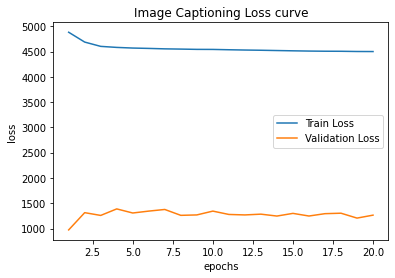

In [ ]:
config = Config()
train(config)

## Exp 2

In [ ]:
class Config(object):
    def __init__(self):
        # Load Data
        self.img_size = 256
        self.batch_size = 32

        # Transformer parameters
        self.patch_size = 16
        self.in_chans = 3
        self.mlp_ratio = 2.
        self.embed_dim = 512
        #self.embed_dim = (self.patch_size**2) * self.in_chans
        self.encoder_depth=8
        self.encoder_heads=8
        self.decoder_depth=4
        self.decoder_heads=8
        self.pos_p=0.0
        self.attn_p=0.2
        self.ffn_p=0.2

        # For Training and Eval
        self.EPOCHS = 20
        self.learning_rate = 0.0001
        assert self.embed_dim % self.encoder_heads == 0, "embed_dim must be a multiple of encoder_heads"
        assert self.embed_dim % self.decoder_heads == 0, "embed_dim must be a multiple of decoder_heads"
        
        # Save the model and the result
        self.load_model = False
        self.save_model= True
        self.save_result = True
        self.models_path = "./learned_models/" # model path that learned models will be saved
        self.saved_model_filename = "image_captioning_model_200731_2.pth.tar"
        self.saved_loss_filename = "image_captioning_loss_200731_2.pkl"


30000
5000
5455
Current Model has 32441328 parameters
Running Model on cuda device
saving checkpoint!
Epoch: 0 / Train Loss: 4757.369761943817 / Validation Loss: 976.2076320648193
saving checkpoint!
Epoch: 1 / Train Loss: 4216.286834716797 / Validation Loss: 1048.0867638587952
saving checkpoint!
Epoch: 2 / Train Loss: 3727.9979457855225 / Validation Loss: 1108.2648072242737
saving checkpoint!
Epoch: 3 / Train Loss: 3500.515816926956 / Validation Loss: 1128.541271686554
saving checkpoint!
Epoch: 4 / Train Loss: 3358.3692150115967 / Validation Loss: 1149.5333189964294
saving checkpoint!
Epoch: 5 / Train Loss: 3235.92457985878 / Validation Loss: 1164.117516040802
saving checkpoint!
Epoch: 6 / Train Loss: 3140.1394896507263 / Validation Loss: 1190.2466039657593
saving checkpoint!
Epoch: 7 / Train Loss: 3052.7343957424164 / Validation Loss: 1205.2176432609558
saving checkpoint!
Epoch: 8 / Train Loss: 2972.8715918064117 / Validation Loss: 1197.5930891036987
saving checkpoint!
Epoch: 9 / Trai

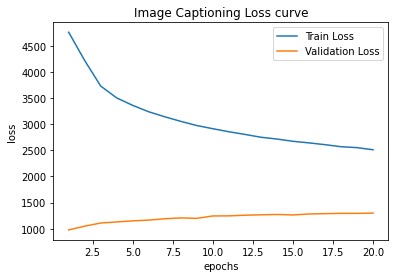

In [ ]:
config = Config()
train(config)

### Exp 3

In [ ]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_size = 384

# Make transforms for training, validating, and testing the model
train_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

val_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

batch_size = 32
num_workers = 4
word_frequency = 5

# Get the dataloaders
train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                        caption_path=train_caption_path, 
                                        word_frequency=word_frequency,
                                        transform=train_transform, 
                                        batch_size=batch_size, 
                                        num_workers=num_workers, 
                                        shuffle=True, 
                                        pin_memory=True)

val_loader, val_dataset = getLoader(root_dir=val_image_dir, 
                                        caption_path=val_caption_path, 
                                        word_frequency=word_frequency,                                    
                                        transform=val_transform, 
                                        batch_size=batch_size, 
                                        num_workers=num_workers, 
                                        shuffle=True, 
                                        pin_memory=True)

test_loader, test_dataset = getLoader(root_dir=test_image_dir, 
                                        caption_path=test_caption_path, 
                                        word_frequency=word_frequency,                                      
                                        transform=test_transform, 
                                        batch_size=batch_size, 
                                        num_workers=num_workers, 
                                        shuffle=True, 
                                        pin_memory=True)

30000
5000
5455


In [ ]:
EPOCHS = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

# Example of Transformer
patch_size = 16
in_chans = 3
mlp_ratio = 2.
embed_dim = 256
#embed_dim = (patch_size**2) * in_chans
hidden_features = int(embed_dim * mlp_ratio)
encoder_depth=12
encoder_heads=8
decoder_depth=4
decoder_heads=8
pos_p=0.0
attn_p=0.1
ffn_p=0.1
vocab_size=len(train_dataset.vocab)

model = Custom_Transformer(img_size = img_size,
                           patch_size = patch_size,
                           in_chans = in_chans,
                           embed_dim = embed_dim,
                           vocab_size = vocab_size,
                           encoder_depth = encoder_depth,
                           decoder_depth = decoder_depth,
                           encoder_heads = encoder_heads,
                           decoder_heads = decoder_heads,
                           mlp_ratio = mlp_ratio,
                           pos_p = pos_p,
                           attn_p = attn_p,
                           ffn_p = ffn_p)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

total_params = sum(
	param.numel() for param in model.parameters()
)
print(f"Current Model has {total_params} parameters")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Running Model on {device} device")

Current Model has 13647660 parameters
Running Model on cuda device


In [ ]:
load_model = False
save_model= True
save_result = True
saved_model_path = os.path.join(models_path, "image_captioning_model_200731.pth.tar")
step = 0
loss_dict = dict()
loss_dict['train'] = list()
loss_dict['val'] = list()
loss_path = os.path.join(models_path, "image_captioning_loss_200731.pkl")

if load_model:
    model, optimizer, step = load_checkpoint(torch.load(saved_model_path), model, optimizer)

for epoch in range(EPOCHS):
    model.train()
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint, filename = saved_model_path)

    # Train
    epoch_train_loss = 0
    for idx, (imgs, captions) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = imgs.to(device)
        captions = captions.to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = captions[:,:-1]
        y_expected = captions[:,1:]

        # Forward
        output = model(imgs, y_input)
        
        train_loss = criterion(output.reshape(-1, output.shape[2]), y_expected.reshape(-1))
        epoch_train_loss += train_loss.item()

        # Backward
        train_loss.backward()
        optimizer.step()

    # Validate
    with torch.no_grad():
        model.eval()
        epoch_val_loss = 0
        for idx, (imgs, captions) in enumerate(val_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = captions[:,:-1]
            y_expected = captions[:,1:]

            # Forward
            output = model(imgs, y_input)
            
            val_loss = criterion(output.reshape(-1, output.shape[2]), y_expected.reshape(-1))
            epoch_val_loss += val_loss.item()

    step+=1
    loss_dict['train'].append(epoch_train_loss)
    loss_dict['val'].append(epoch_val_loss)
    print(f"Epoch: {epoch} / Train Loss: {epoch_train_loss} / Validation Loss: {epoch_val_loss}")

# Save loss history 
if save_result:
    with open(loss_path, 'wb') as f:
        pickle.dump(loss_dict, f)

saving checkpoint!
Epoch: 0 / Train Loss: 2550.8919488191605 / Validation Loss: 1009.6061401367188
saving checkpoint!
Epoch: 1 / Train Loss: 1467.3484588861465 / Validation Loss: 992.7778663635254
saving checkpoint!
Epoch: 2 / Train Loss: 1126.6613512039185 / Validation Loss: 1017.9664421081543
saving checkpoint!
Epoch: 3 / Train Loss: 943.8435942530632 / Validation Loss: 1019.9210410118103
saving checkpoint!
Epoch: 4 / Train Loss: 840.3898208141327 / Validation Loss: 1033.7683420181274
saving checkpoint!
Epoch: 5 / Train Loss: 778.9295016527176 / Validation Loss: 1087.3031611442566
saving checkpoint!
Epoch: 6 / Train Loss: 729.5199763178825 / Validation Loss: 1079.2211027145386
saving checkpoint!
Epoch: 7 / Train Loss: 692.3223264217377 / Validation Loss: 1100.2316823005676
saving checkpoint!
Epoch: 8 / Train Loss: 664.6382794082165 / Validation Loss: 1127.5831723213196
saving checkpoint!
Epoch: 9 / Train Loss: 639.8651024103165 / Validation Loss: 1133.2075867652893
saving checkpoint!

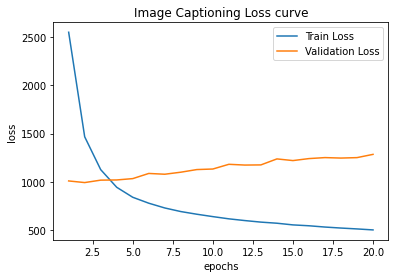

In [ ]:
plt.plot(list(range(1, EPOCHS+1)), loss_dict['train'], label='Train Loss')
plt.plot(list(range(1, EPOCHS+1)), loss_dict['val'], label='Validation Loss')
plt.title('Image Captioning Loss curve')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), os.path.join(models_path, "my_cptr_200731.ckpt"))

## Exp 4

In [ ]:
import torch
from torch import nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
channel_number = 512


class ScaledDotProductAttention(nn.Module):
    def __init__(self, QKVdim):
        super(ScaledDotProductAttention, self).__init__()
        self.QKVdim = QKVdim

    def forward(self, Q, K, V, attn_mask):
        """
        :param Q: [batch_size, n_heads, -1(len_q), QKVdim]
        :param K, V: [batch_size, n_heads, -1(len_k=len_v), QKVdim]
        :param attn_mask: [batch_size, n_heads, len_q, len_k]
        """
        # scores: [batch_size, n_heads, len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.QKVdim)
        # Fills elements of self tensor with value where mask is True.
        scores.to(device).masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)  # [batch_size, n_heads, len_q, len_k]
        context = torch.matmul(attn, V).to(device)  # [batch_size, n_heads, len_q, QKVdim]
        return context, attn


class Multi_Head_Attention(nn.Module):
    def __init__(self, Q_dim, K_dim, QKVdim, n_heads=8, dropout=0.1):
        super(Multi_Head_Attention, self).__init__()
        self.W_Q = nn.Linear(Q_dim, QKVdim * n_heads).to(device)
        self.W_K = nn.Linear(K_dim, QKVdim * n_heads).to(device)
        self.W_V = nn.Linear(K_dim, QKVdim * n_heads).to(device)
        self.n_heads = n_heads
        self.QKVdim = QKVdim
        self.embed_dim = Q_dim
        self.dropout = nn.Dropout(p=dropout)
        self.W_O = nn.Linear(self.n_heads * self.QKVdim, self.embed_dim).to(device)

    def forward(self, Q, K, V, attn_mask):
        """
        In self-encoder attention:
                Q = K = V: [batch_size, num_pixels=196, encoder_dim=2048]
                attn_mask: [batch_size, len_q=196, len_k=196]
        In self-decoder attention:
                Q = K = V: [batch_size, max_len=52, embed_dim=512]
                attn_mask: [batch_size, len_q=52, len_k=52]
        encoder-decoder attention:
                Q: [batch_size, 52, 512] from decoder
                K, V: [batch_size, 196, 2048] from encoder
                attn_mask: [batch_size, len_q=52, len_k=196]
        return _, attn: [batch_size, n_heads, len_q, len_k]
        """
        residual, batch_size = Q, Q.size(0)
        # q_s: [batch_size, n_heads=8, len_q, QKVdim] k_s/v_s: [batch_size, n_heads=8, len_k, QKVdim]
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.QKVdim).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.QKVdim).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.QKVdim).transpose(1, 2)
        print(f"Q: {Q.shape}, K: {K.shape}, V: {V.shape}")
        print(f"q_s: {q_s.shape}, k_s: {k_s.shape}, v_s: {v_s.shape}")
        # attn_mask: [batch_size, self.n_heads, len_q, len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        # attn: [batch_size, n_heads, len_q, len_k]
        # context: [batch_size, n_heads, len_q, QKVdim]
        context, attn = ScaledDotProductAttention(self.QKVdim)(q_s, k_s, v_s, attn_mask)
        # context: [batch_size, n_heads, len_q, QKVdim] -> [batch_size, len_q, n_heads * QKVdim]
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.QKVdim).to(device)
        # output: [batch_size, len_q, embed_dim]
        output = self.W_O(context)
        output = self.dropout(output)
        print("After output + residual in MHA: ", nn.LayerNorm(self.embed_dim).to(device)(output + residual).shape)
        return nn.LayerNorm(self.embed_dim).to(device)(output + residual), attn


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, embed_dim, d_ff, dropout):
        super(PoswiseFeedForwardNet, self).__init__()
        """
        Two fc layers can also be described by two cnn with kernel_size=1.
        """
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=d_ff, kernel_size=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=embed_dim, kernel_size=1).to(device)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_dim = embed_dim

    def forward(self, inputs):
        """
        encoder: inputs: [batch_size, len_q=196, embed_dim=2048]
        decoder: inputs: [batch_size, max_len=52, embed_dim=512]
        """
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        return nn.LayerNorm(self.embed_dim).to(device)(output + residual)


class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, dropout, attention_method, n_heads):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = Multi_Head_Attention(Q_dim=embed_dim, K_dim=embed_dim, QKVdim=64, n_heads=n_heads, dropout=dropout)
        if attention_method == "ByPixel":
            self.dec_enc_attn = Multi_Head_Attention(Q_dim=embed_dim, K_dim=2048, QKVdim=64, n_heads=n_heads, dropout=dropout)
            self.pos_ffn = PoswiseFeedForwardNet(embed_dim=embed_dim, d_ff=2048, dropout=dropout)
        elif attention_method == "ByChannel":
            self.dec_enc_attn = Multi_Head_Attention(Q_dim=embed_dim, K_dim=196, QKVdim=64, n_heads=n_heads, dropout=dropout)
            self.pos_ffn = PoswiseFeedForwardNet(embed_dim=embed_dim, d_ff=2048, dropout=dropout)  # need to change

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        """
        :param dec_inputs: [batch_size, max_len=52, embed_dim=512]
        :param enc_outputs: [batch_size, num_pixels=196, 2048]
        :param dec_self_attn_mask: [batch_size, 52, 52]
        :param dec_enc_attn_mask: [batch_size, 52, 196]
        """
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        print("Decoder: Output of Self Attention: ", dec_outputs.shape)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        print("Decoder: Output of Encoder-Decoder Attention: ", dec_outputs.shape)
        dec_outputs = self.pos_ffn(dec_outputs)
        print("Decoder: Output of FFN: ", dec_outputs.shape)
        return dec_outputs, dec_self_attn, dec_enc_attn


class Decoder(nn.Module):
    def __init__(self, n_layers, vocab_size, embed_dim, dropout, attention_method, n_heads):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.tgt_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding.from_pretrained(self.get_position_embedding_table(embed_dim), freeze=True)
        self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList([DecoderLayer(embed_dim, dropout, attention_method, n_heads) for _ in range(n_layers)])
        self.projection = nn.Linear(embed_dim, vocab_size, bias=False).to(device)
        self.attention_method = attention_method

    def get_position_embedding_table(self, embed_dim):
        def cal_angle(position, hid_idx):
            return position / np.power(10000, 2 * (hid_idx // 2) / embed_dim)
        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_idx) for hid_idx in range(embed_dim)]

        embedding_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(52)])
        embedding_table[:, 0::2] = np.sin(embedding_table[:, 0::2])  # dim 2i
        embedding_table[:, 1::2] = np.cos(embedding_table[:, 1::2])  # dim 2i+1
        return torch.FloatTensor(embedding_table).to(device)

    def get_attn_pad_mask(self, seq_q, seq_k):
        batch_size, len_q = seq_q.size()
        batch_size, len_k = seq_k.size()
        # In wordmap, <pad>:0
        # pad_attn_mask: [batch_size, 1, len_k], one is masking
        pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
        return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

    def get_attn_subsequent_mask(self, seq):
        attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
        subsequent_mask = np.triu(np.ones(attn_shape), k=1)
        subsequent_mask = torch.from_numpy(subsequent_mask).byte().to(device)
        return subsequent_mask

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: [batch_size, num_pixels=196, 2048]
        :param encoded_captions: [batch_size, 52]
        :param caption_lengths: [batch_size, 1]
        """
        batch_size = encoder_out.size(0)
        # Sort input data by decreasing lengths.
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        print("caption lengths in decoder :", caption_lengths)
        decode_lengths = (caption_lengths - 1).tolist()
        print("decode  lengths in decoder :", decode_lengths)

        # dec_outputs: [batch_size, max_len=52, embed_dim=512]
        # dec_self_attn_pad_mask: [batch_size, len_q=52, len_k=52], 1 if id=0(<pad>)
        # dec_self_attn_subsequent_mask: [batch_size, 52, 52], Upper triangle of an array with 1.
        # dec_self_attn_mask for self-decoder attention, the position whose val > 0 will be masked.
        # dec_enc_attn_mask for encoder-decoder attention.
        # e.g. 9488, 23, 53, 74, 0, 0  |  dec_self_attn_mask:
        # 0 1 1 1 2 2
        # 0 0 1 1 2 2
        # 0 0 0 1 2 2
        # 0 0 0 0 2 2
        # 0 0 0 0 1 2
        # 0 0 0 0 1 1
        print("Output of Target Embedding: ", self.tgt_emb(encoded_captions).shape)
        print("Output after Positional Encoding: ", self.pos_emb(torch.LongTensor([list(range(52))]*batch_size).to(device)).shape)
        dec_outputs = self.tgt_emb(encoded_captions) + self.pos_emb(torch.LongTensor([list(range(52))]*batch_size).to(device))
        print("Output after Target Embedding and Positional Encoding: ", dec_outputs.shape)
        
        dec_outputs = self.dropout(dec_outputs)
        dec_self_attn_pad_mask = self.get_attn_pad_mask(encoded_captions, encoded_captions)
        dec_self_attn_subsequent_mask = self.get_attn_subsequent_mask(encoded_captions)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        if self.attention_method == "ByPixel":
            dec_enc_attn_mask = (torch.tensor(np.zeros((batch_size, 52, 196))).to(device) == torch.tensor(np.ones((batch_size, 52, 196))).to(device))
        elif self.attention_method == "ByChannel":
            dec_enc_attn_mask = (torch.tensor(np.zeros((batch_size, 52, channel_number))).to(device) == torch.tensor(np.ones((batch_size, 52, channel_number))).to(device))

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # attn: [batch_size, n_heads, len_q, len_k]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, encoder_out, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        print("Output after Decode Layers: ", dec_outputs.shape)
        predictions = self.projection(dec_outputs)
        print("Output after Projection Layers: ", predictions.shape)
        return predictions, encoded_captions, decode_lengths, sort_ind, dec_self_attns, dec_enc_attns


class EncoderLayer(nn.Module):
    def __init__(self, dropout, attention_method, n_heads):
        super(EncoderLayer, self).__init__()
        """
        In "Attention is all you need" paper, dk = dv = 64, h = 8, N=6
        """
        if attention_method == "ByPixel":
            self.enc_self_attn = Multi_Head_Attention(Q_dim=2048, K_dim=2048, QKVdim=64, n_heads=n_heads, dropout=dropout)
            self.pos_ffn = PoswiseFeedForwardNet(embed_dim=2048, d_ff=4096, dropout=dropout)
        elif attention_method == "ByChannel":
            self.enc_self_attn = Multi_Head_Attention(Q_dim=196, K_dim=196, QKVdim=64, n_heads=n_heads, dropout=dropout)
            self.pos_ffn = PoswiseFeedForwardNet(embed_dim=196, d_ff=512, dropout=dropout)

    def forward(self, enc_inputs, enc_self_attn_mask):
        """
        :param enc_inputs: [batch_size, num_pixels=196, 2048]
        :param enc_outputs: [batch_size, len_q=196, d_model=2048]
        :return: attn: [batch_size, n_heads=8, 196, 196]
        """
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn


class Encoder(nn.Module):
    def __init__(self, n_layers, dropout, attention_method, n_heads):
        super(Encoder, self).__init__()
        if attention_method == "ByPixel":
            self.pos_emb = nn.Embedding.from_pretrained(self.get_position_embedding_table(), freeze=True)
        # self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList([EncoderLayer(dropout, attention_method, n_heads) for _ in range(n_layers)])
        self.attention_method = attention_method

    def get_position_embedding_table(self):
        def cal_angle(position, hid_idx):
            x = position % 14
            y = position // 14
            x_enc = x / np.power(10000, hid_idx / 1024)
            y_enc = y / np.power(10000, hid_idx / 1024)
            return np.sin(x_enc), np.sin(y_enc)
        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_idx)[0] for hid_idx in range(1024)] + [cal_angle(position, hid_idx)[1] for hid_idx in range(1024)]

        embedding_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(196)])
        return torch.FloatTensor(embedding_table).to(device)

    def forward(self, encoder_out):
        """
        :param encoder_out: [batch_size, num_pixels=196, dmodel=2048]
        """
        batch_size = encoder_out.size(0)
        positions = encoder_out.size(1)
        if self.attention_method == "ByPixel":
            encoder_out = encoder_out + self.pos_emb(torch.LongTensor([list(range(positions))]*batch_size).to(device))
        # encoder_out = self.dropout(encoder_out)
        # enc_self_attn_mask: [batch_size, 196, 196]
        enc_self_attn_mask = (torch.tensor(np.zeros((batch_size, positions, positions))).to(device)
                              == torch.tensor(np.ones((batch_size, positions, positions))).to(device))
        enc_self_attns = []
        for layer in self.layers:
            encoder_out, enc_self_attn = layer(encoder_out, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        
        return encoder_out, enc_self_attns


class Transformer(nn.Module):
    """
    See paper 5.4: "Attention Is All You Need" - https://arxiv.org/abs/1706.03762
    "Apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
    In addition, apply dropout to the sums of the embeddings and the positional encodings in both the encoder
    and decoder stacks." (Now, we dont't apply dropout to the encoder embeddings)
    """
    def __init__(self, vocab_size, embed_dim, encoder_layers, decoder_layers, dropout=0.1, attention_method="ByPixel", n_heads=8):
        super(Transformer, self).__init__()
        self.encoder = Encoder(encoder_layers, dropout, attention_method, n_heads)
        self.decoder = Decoder(decoder_layers, vocab_size, embed_dim, dropout, attention_method, n_heads)
        self.embedding = self.decoder.tgt_emb
        self.attention_method = attention_method

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def forward(self, enc_inputs, encoded_captions, caption_lengths):
        """
        preprocess: enc_inputs: [batch_size, 14, 14, 2048]/[batch_size, 196, 2048] -> [batch_size, 196, 2048]
        encoded_captions: [batch_size, 52]
        caption_lengths: [batch_size, 1], not used
        The encoder or decoder is composed of a stack of n_layers=6 identical layers.
        One layer in encoder: Multi-head Attention(self-encoder attention) with Norm & Residual
                            + Feed Forward with Norm & Residual
        One layer in decoder: Masked Multi-head Attention(self-decoder attention) with Norm & Residual
                            + Multi-head Attention(encoder-decoder attention) with Norm & Residual
                            + Feed Forward with Norm & Residual
        """
        batch_size = enc_inputs.size(0)
        encoder_dim = enc_inputs.size(-1)
        if self.attention_method == "ByPixel":
            enc_inputs = enc_inputs.view(batch_size, -1, encoder_dim)
        elif self.attention_method == "ByChannel":
            enc_inputs = enc_inputs.view(batch_size, -1, encoder_dim).permute(0, 2, 1)  # (batch_size, 2048, 196)

        print("** Running Transformer Encoder")
        encoder_out, enc_self_attns = self.encoder(enc_inputs)
        print("Transformer Encoder encoder_out shape: ", encoder_out.shape)
        # encoder_out: [batch_size, 196, 2048]
        print("** Running Transformer Decoder")
        predictions, encoded_captions, decode_lengths, sort_ind, dec_self_attns, dec_enc_attns = self.decoder(encoder_out, encoded_captions, caption_lengths)
        alphas = {"enc_self_attns": enc_self_attns, "dec_self_attns": dec_self_attns, "dec_enc_attns": dec_enc_attns}
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
class CNN_Encoder(nn.Module):
    """
    CNN_Encoder.
    """

    def __init__(self, encoded_image_size=14, attention_method="ByPixel"):
        super(CNN_Encoder, self).__init__()
        self.enc_image_size = encoded_image_size
        self.attention_method = attention_method

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        # Specifically, Remove: AdaptiveAvgPool2d(output_size=(1, 1)), Linear(in_features=2048, out_features=1000, bias=True)]
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        if self.attention_method == "ByChannel":
            self.cnn1 = nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
            self.bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.relu = nn.ReLU(inplace=True)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images [batch_size, encoded_image_size=14, encoded_image_size=14, 2048]
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        if self.attention_method == "ByChannel":  # [batch_size, 2048, 8, 8] -> # [batch_size, 512, 8, 8]
            out = self.relu(self.bn1(self.cnn1(out)))
        out = self.adaptive_pool(out)  # [batch_size, 2048/512, 8, 8] -> [batch_size, 2048/512, 14, 14]
        out = out.permute(0, 2, 3, 1)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # [batch_size_t, num_pixels=196, 2048] -> [batch_size_t, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden)  # [batch_size_t, decoder_dim=512] -> [batch_size_t, attention_dim]
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # [batch_size_t, num_pixels=196, attention_dim] -> [batch_size_t, num_pixels]
        alpha = self.softmax(att)  # [batch_size_t, num_pixels=196]
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # [batch_size_t, encoder_dim=2048]

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution
        self.fine_tune_embeddings()

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # [batch_size, 196, 2048] -> [batch_size, 2048]
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        # [batch_size, 14, 14, 2048]/[batch_size, 196, 2048] -> [batch_size, 196, 2048]
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image -> [batch_size, num_pixels=196, encoder_dim=2048]
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? For each of data in the batch, when len(prediction) = len(caption_lengths), Stop.
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # [batch_size, max_caption_length=52, embed_dim]

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # [batch_size, decoder_dim]

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            # alpha: [batch_size_t, 196]
            # attention_weighted_encoding: [batch_size_t, 2048]
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            # torch.cat([batch_size_t, 500], [batch_size_t, 2048], dim=1) = [batch_size_t, 2548] -> [batch_size_t, 512]
            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))  # [batch_size_t, vocab_size]
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_size = 256 #MSCOCO image size of 256x256

train_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                         caption_path=train_caption_path, 
                                         word_frequency=5,
                                         transform=train_transform, 
                                         batch_size=32, 
                                         num_workers=0, 
                                         shuffle=True, 
                                         pin_memory=True)


30000


In [ ]:
imgs, captions, caplens = next(iter(train_loader))
print(imgs.shape)
print(captions.shape)
print(caplens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 52])
torch.Size([32, 1])


In [ ]:
encoder_lr = 1e-4
decoder_lr = 1e-6 #learning rate for decoder
fine_tune_encoder = False
emb_dim = 300 #dimension of word embeddings
encoder_layers = 2 #the number of layers of encoder in Transformer
decoder_layers = 6 #the number of layers of decoder in Transformer
dropout = 0.1 #dropout
attention_method = "ByPixel" #which attention method to use?
n_heads = 8 #Multi-head attention
embedding_path = os.path.join("./data", "glove.6B.300d.txt")
fine_tune_embedding = False
word_map = train_dataset.vocab.stoi
print("Number of words in word map: ", len(word_map))

Number of words in word map:  2544


In [ ]:
encoder = CNN_Encoder()
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                     lr=encoder_lr) if fine_tune_encoder else None
decoder = Transformer(vocab_size=len(word_map), embed_dim=emb_dim, encoder_layers=encoder_layers,
                                  decoder_layers=decoder_layers, dropout=dropout,
                                  attention_method=attention_method, n_heads=n_heads)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

In [ ]:
import codecs
all_word_embeds = {}
for i, line in enumerate(codecs.open(embedding_path, 'r', 'utf-8')):
    s = line.strip().split()
    all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

In [ ]:
len(all_word_embeds.keys())
emb_dim = list(all_word_embeds.values())[-1].size
print(emb_dim) #Each word is descrited in 300 dimensions
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_map), emb_dim))

300


In [ ]:
for w in word_map:
    if w in all_word_embeds:
        word_embeds[word_map[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_map[w]] = all_word_embeds[w.lower()]
    else:
        # <pad> <start> <end> <unk>
        embedding_i = torch.ones(1, emb_dim)
        torch.nn.init.xavier_uniform_(embedding_i)
        word_embeds[word_map[w]] = embedding_i

word_embeds = torch.FloatTensor(word_embeds)
decoder.load_pretrained_embeddings(word_embeds)
decoder.fine_tune_embeddings(fine_tune_embedding)
print('Loaded {} pre-trained word embeddings.'.format(len(word_embeds)))

Loaded 2544 pre-trained word embeddings.


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
print("imgs shape before encoder (CNN): ", imgs.shape)
enc_imgs = encoder(imgs)
print("imgs shape after encoder (CNN): ", enc_imgs.shape)

imgs shape before encoder (CNN):  torch.Size([32, 3, 256, 256])
imgs shape after encoder (CNN):  torch.Size([32, 14, 14, 2048])


In [ ]:
scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(enc_imgs, captions, caplens)

** Running Transformer Encoder
Q: torch.Size([32, 196, 2048]), K: torch.Size([32, 196, 2048]), V: torch.Size([32, 196, 2048])
q_s: torch.Size([32, 8, 196, 64]), k_s: torch.Size([32, 8, 196, 64]), v_s: torch.Size([32, 8, 196, 64])
After output + residual in MHA:  torch.Size([32, 196, 2048])
Q: torch.Size([32, 196, 2048]), K: torch.Size([32, 196, 2048]), V: torch.Size([32, 196, 2048])
q_s: torch.Size([32, 8, 196, 64]), k_s: torch.Size([32, 8, 196, 64]), v_s: torch.Size([32, 8, 196, 64])
After output + residual in MHA:  torch.Size([32, 196, 2048])
Transformer Encoder encoder_out shape:  torch.Size([32, 196, 2048])
** Running Transformer Decoder
caption lengths in decoder : tensor([20, 18, 18, 17, 16, 15, 15, 15, 14, 14, 13, 13, 13, 12, 12, 12, 12, 11,
        11, 11, 11, 11, 10, 10, 10,  9,  9,  9,  8,  8,  7,  6])
decode  lengths in decoder : [19, 17, 17, 16, 15, 14, 14, 14, 13, 13, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 8, 8, 8, 7, 7, 6, 5]
Output of Target Embedding: 

In [ ]:
print("Scores shape: ", scores.shape)
print("Scores shape: ", caps_sorted.shape)
print("decode_lengths  : ", decode_lengths)
print("original caplens: ", caplens.squeeze(1).tolist())
print("alphas keys: ", alphas.keys())
print("Scores shape: ", sort_ind.shape)

Scores shape:  torch.Size([32, 52, 2544])
Scores shape:  torch.Size([32, 52])
decode_lengths  :  [19, 17, 17, 16, 15, 14, 14, 14, 13, 13, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 8, 8, 8, 7, 7, 6, 5]
original caplens:  [10, 16, 11, 14, 8, 10, 18, 15, 11, 8, 9, 12, 9, 11, 11, 12, 6, 13, 14, 12, 10, 18, 13, 20, 15, 15, 17, 11, 13, 12, 9, 7]
alphas keys:  dict_keys(['enc_self_attns', 'dec_self_attns', 'dec_enc_attns'])
Scores shape:  torch.Size([32])


In [ ]:
# Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
targets = caps_sorted[:, 1:]

In [ ]:
scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

In [ ]:
print(scores.shape)
print(targets.shape)

torch.Size([358, 2544])
torch.Size([358])


In [ ]:
loss = criterion(scores, targets)
print(loss)

tensor(8.0074, grad_fn=<NllLossBackward0>)


#5. Inference

In [ ]:
model = Custom_Transformer(img_size = img_size,
                           patch_size = patch_size,
                           in_chans = in_chans,
                           embed_dim = embed_dim,
                           vocab_size = vocab_size,
                           encoder_depth = encoder_depth,
                           decoder_depth = decoder_depth,
                           encoder_heads = encoder_heads,
                           decoder_heads = decoder_heads,
                           mlp_ratio = mlp_ratio,
                           pos_p = pos_p,
                           attn_p = attn_p,
                           ffn_p = ffn_p)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

total_params = sum(
	param.numel() for param in model.parameters()
)
print(f"Current Model has {total_params} parameters")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Running Model on {device} device")

Current Model has 179963813 parameters
Running Model on cuda device


In [ ]:
load_model = True
saved_model_path = os.path.join(models_path, "my_checkpoint.pth.tar")
step = 0
loss_dict = dict()
loss_dict['train'] = list()
loss_dict['val'] = list()
loss_path = os.path.join(models_path, "image_captioning_loss.pkl")

if load_model:
    model, optimizer, step = load_checkpoint(torch.load(saved_model_path), model, optimizer)

loading checkpoint!


In [ ]:
model

Custom_Transformer(
  (encoder): Custom_TransformerEncoder(
    (patch_embed): PatchEmbed(
      (patching): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): EncoderBlock(
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ffn): FFN(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=

In [ ]:
imgs, captions = next(iter(test_loader))

torch.Size([32, 3, 256, 256])
torch.Size([32, 21])
tensor([    1, 57183, 49641, 57582, 57338, 57617,     3, 57428, 57617,     3,
        50310, 57487, 55807, 57307, 53396, 57621,     2,     0,     0,     0,
            0])
<SOS> an elderly man wearing a <UNK> riding a <UNK> scooter while shopping for shoes . <EOS> <PAD> <PAD> <PAD> <PAD> 

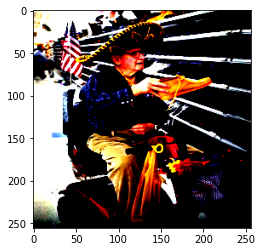

In [ ]:
print(imgs.shape)
print(captions.shape)

x = imgs[0]
y = captions[0]
plt.imshow(x.permute(1,2,0))
print(y)
for i in y:
    print(test_dataset.vocab.itos[int(i)],end=" ")

In [ ]:
imgs = imgs.to(device)
features = model.encoder(imgs)

In [ ]:
output = model.final_layer(features)

RuntimeError: ignored

In [ ]:
batch_size = 10
len_q = 196
len_k = 196
max_len = 52
embed_dim = 512
encoder_dim = 2048
QKVdim = 64
Q_dim=embed_dim
K_dim=encoder_dim
n_heads=8

Q = torch.ones([batch_size, max_len, embed_dim])
K = torch.ones([batch_size, len_k, encoder_dim])
V = torch.ones([batch_size, len_k, encoder_dim])

In [ ]:
W_Q = nn.Linear(Q_dim, QKVdim * n_heads)
W_K = nn.Linear(K_dim, QKVdim * n_heads)
W_V = nn.Linear(K_dim, QKVdim * n_heads)
W_O = nn.Linear(n_heads * QKVdim, embed_dim)

In [ ]:
W_O

Linear(in_features=512, out_features=512, bias=True)

In [ ]:
q_s = W_Q(Q).view(batch_size, -1, n_heads, QKVdim).transpose(1, 2)
k_s = W_K(K).view(batch_size, -1, n_heads, QKVdim).transpose(1, 2)
v_s = W_V(V).view(batch_size, -1, n_heads, QKVdim).transpose(1, 2)

In [ ]:
print(q_s.shape)
print(k_s.shape)
print(v_s.shape)

torch.Size([10, 8, 52, 64])
torch.Size([10, 8, 196, 64])
torch.Size([10, 8, 196, 64])


In [ ]:
scores = torch.matmul(q_s, k_s.transpose(-1, -2)) / np.sqrt(QKVdim)
print("Scores shape: ", scores.shape)
attn = nn.Softmax(dim=-1)(scores)
print("Attention shape: ", attn.shape)
context = torch.matmul(attn, v_s)
print("Context shape: ", context.shape) #[batch_size, n_heads, len_q, QKVdim]

Scores shape:  torch.Size([10, 8, 52, 196])
Attention shape:  torch.Size([10, 8, 52, 196])
Context shape:  torch.Size([10, 8, 52, 64])


In [ ]:
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * QKVdim) # output: [batch_size, len_q, embed_dim]
print("Context shape for final linear layer: ", context.shape) #[batch_size, n_heads, len_q, QKVdim]

Context shape for final linear layer:  torch.Size([10, 52, 512])


In [ ]:
output = W_O(context)
print("Output shape: ", output.shape)

Output shape:  torch.Size([10, 52, 512])


In [ ]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_size = 256

train_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                         caption_path=train_caption_path, 
                                         word_frequency=5,
                                         transform=train_transform, 
                                         batch_size=10, 
                                         num_workers=0, 
                                         shuffle=True, 
                                         pin_memory=True)


NameError: ignored